In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [24]:
df = pd.read_csv('austin_weather.csv')
df.Date = pd.to_datetime(df.Date)
print(df.head())
print(df.tail())

        Date  TempHighF  TempAvgF  TempLowF DewPointHighF DewPointAvgF  \
0 2013-12-21         74        60        45            67           49   
1 2013-12-22         56        48        39            43           36   
2 2013-12-23         58        45        32            31           27   
3 2013-12-24         61        46        31            36           28   
4 2013-12-25         58        50        41            44           40   

  DewPointLowF HumidityHighPercent HumidityAvgPercent HumidityLowPercent  ...  \
0           43                  93                 75                 57  ...   
1           28                  93                 68                 43  ...   
2           23                  76                 52                 27  ...   
3           21                  89                 56                 22  ...   
4           36                  86                 71                 56  ...   

  SeaLevelPressureAvgInches SeaLevelPressureLowInches VisibilityHigh

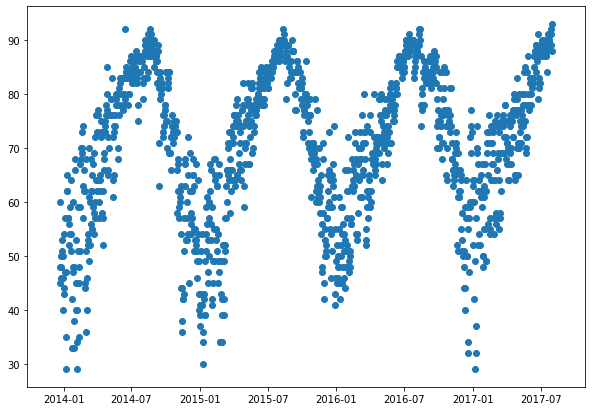

In [25]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(df.Date, df.TempAvgF)

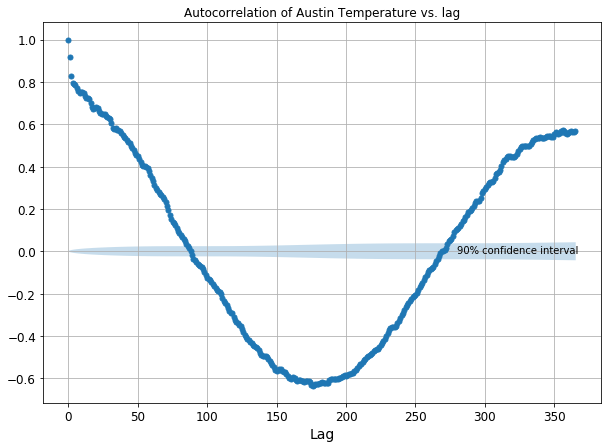

In [26]:
max_lag = 365
fig, ax = plt.subplots(figsize = (10, 7))
acf_plot = plot_acf(x = df.TempAvgF,
                    ax = ax,
                    lags = max_lag,
                    use_vlines = False,
                    alpha = 0.9,
                    title = 'Autocorrelation of Austin Temperature vs. lag')
ax.grid(True)
ax.text(280, -0.01, '90% confidence interval')
ax.set_xlabel('Lag', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)

In [27]:
corr0 = np.correlate(df.TempAvgF[0: ] - 
                     df.TempAvgF.mean(), 
                     df.TempAvgF[0: ] - 
                     df.TempAvgF.mean(), 
                     mode = 'valid')
corrs = [np.correlate(df.TempAvgF[:(df.TempAvgF.shape[0] - i)] - 
                      df.TempAvgF.mean(), 
                      df.TempAvgF[i: ] - 
                      df.TempAvgF.mean(), 
                      mode = 'valid')          
         for i in range(max_lag)] / corr0

In [28]:
#
# utility function to plot out a range of 
# plots depicting self-correlation
#
def plot_lag_grid(series, corrs, 
                  axis_min, axis_max, 
                  num_plots, total_lag,
                  n_rows, n_cols):
    lag_step = int(total_lag / num_plots)
    fig = plt.figure(figsize = (18, 16))
    for i, var_name in enumerate(range(num_plots)):
        corr = corrs[lag_step * i]
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        ax.scatter(series, series.shift(lag_step * i))
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        ax.set_title('lag = ' + str(lag_step * i))
        ax.text(axis_min + 0.05 * (axis_max - axis_min),
                axis_max - 0.05 * (axis_max - axis_min),
                'correlation = ' + str(round(corr[0], 3)))
    fig.tight_layout()
    plt.show()

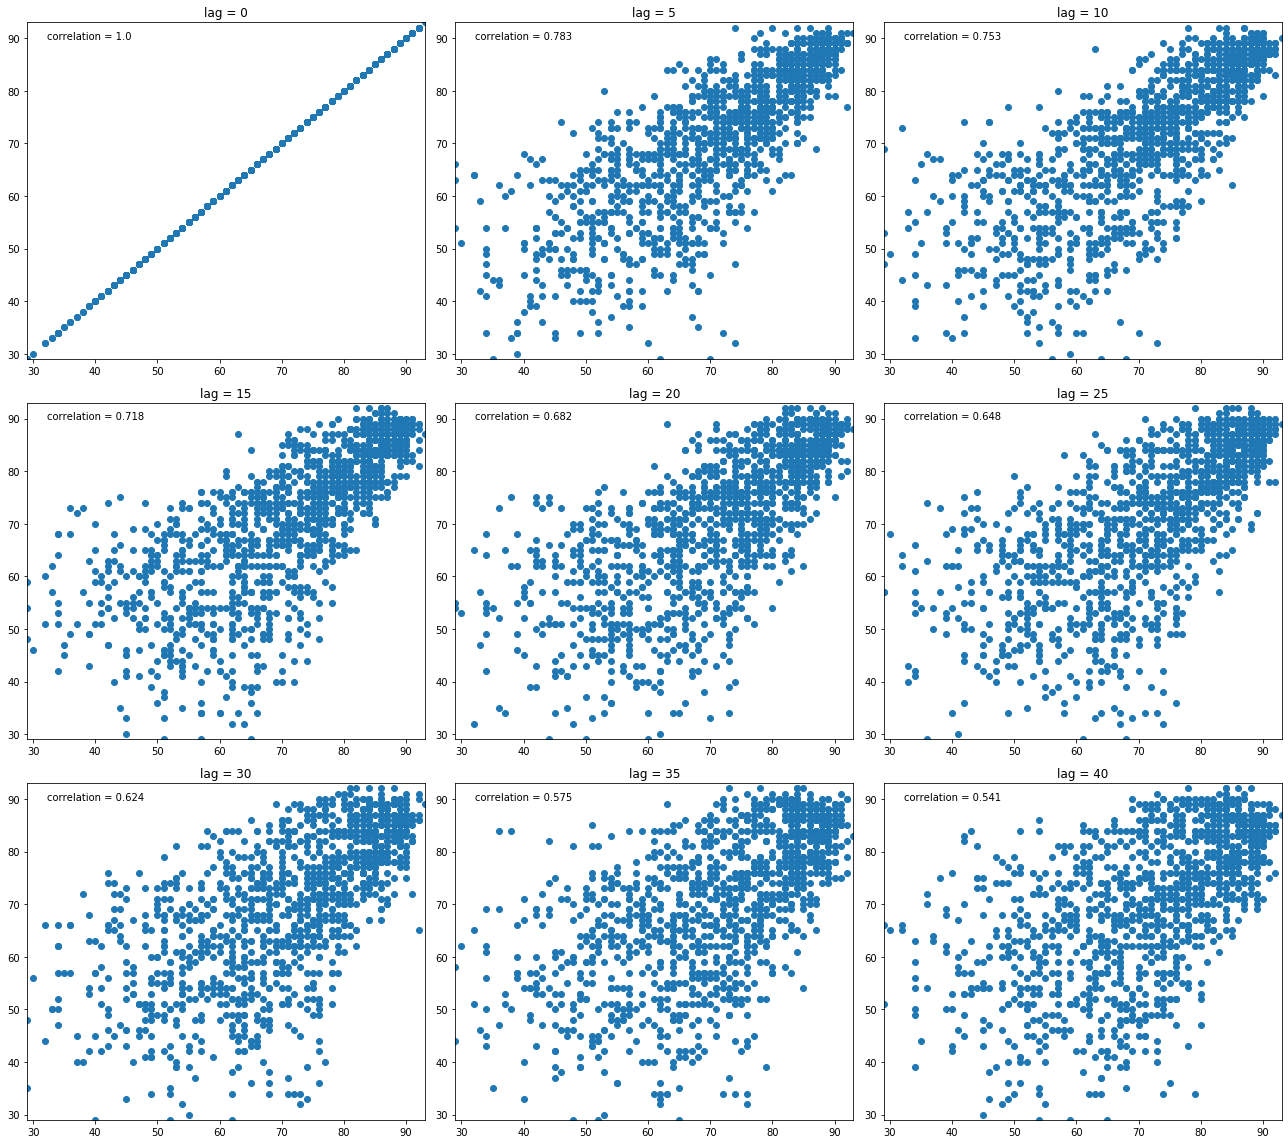

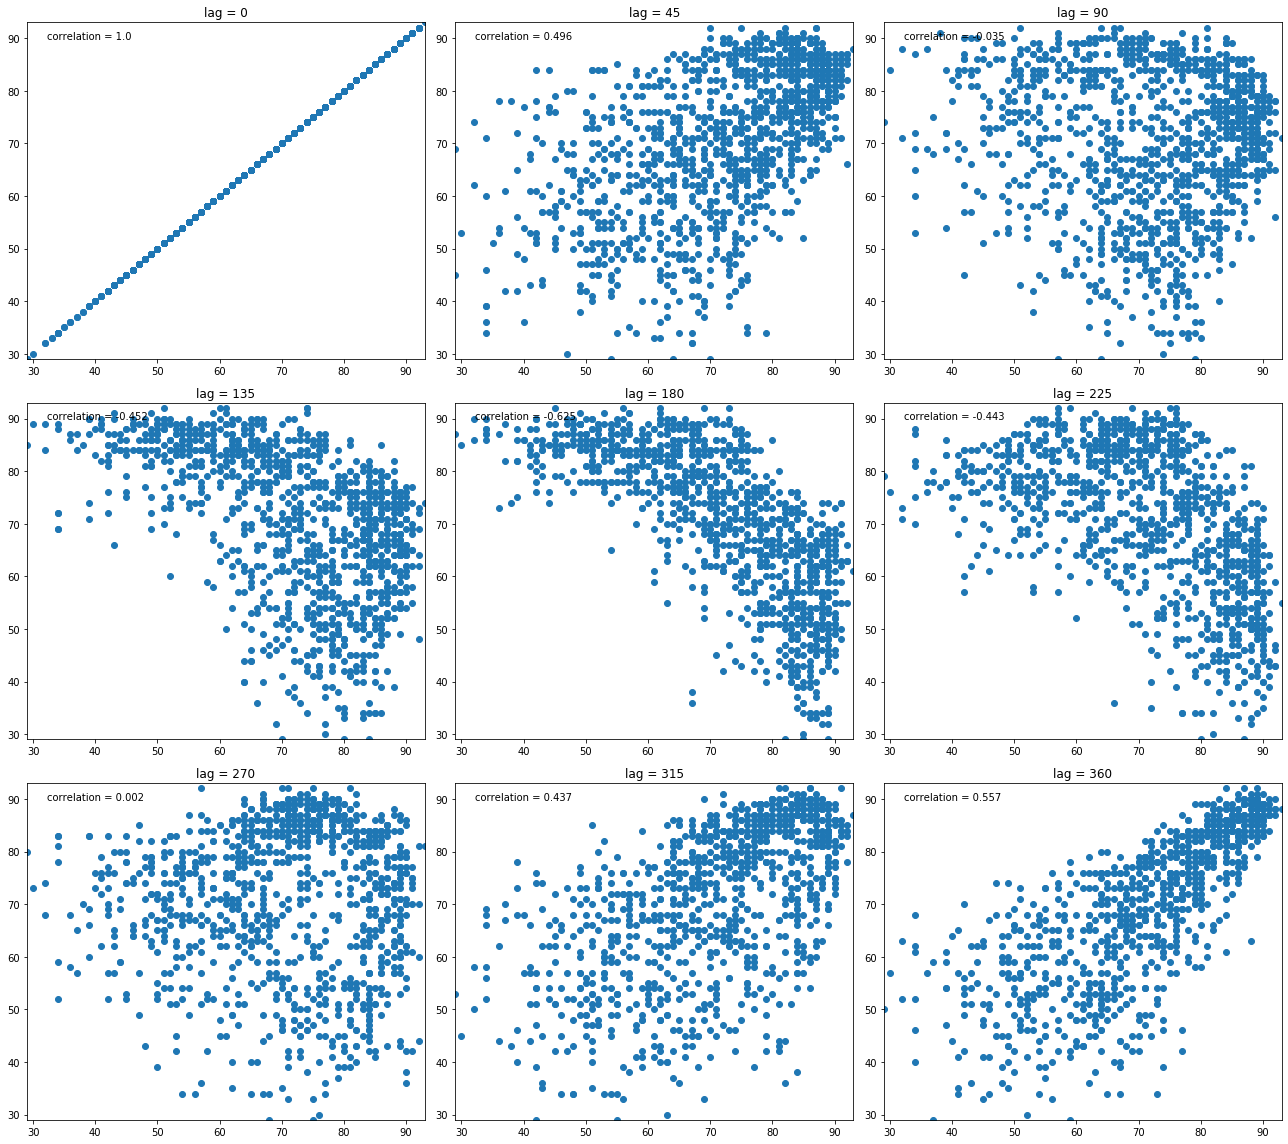

In [29]:
plot_lag_grid(df.TempAvgF, corrs,
              df.TempAvgF.min(), df.TempAvgF.max(),
              9, 45,
              3, 3)
plot_lag_grid(df.TempAvgF, corrs,
              df.TempAvgF.min(), df.TempAvgF.max(),
              9, 405,
              3, 3)

In [30]:
#
# statsmodels AR function builds an autoregression model
# using all the defaults, it will determine the max lag
# and provide all the model coefficients
#
model = AR(df.TempAvgF)
model_fit = model.fit()
#
# model fit now contains all the model information
# 
max_lag = model_fit.k_ar
#
# note that by using defaults, the maximum lag is 
# computed as round(12*(nobs/100.)**(1/4.))
# see https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AR.fit.html#statsmodels.tsa.ar_model.AR.fit
#
print('Max Lag: ' + str(max_lag))
print('Coefficients: \n' + str(model_fit.params))
#
# how far into the future we want to predict
#
max_forecast = 365
#
# generate predictions from the model
#
pred_temp = pd.DataFrame({'pred_temp': 
                           model_fit.predict(start = max_lag,
                                             end = df.shape[0] + 
                                             max_forecast - 1)})
#
# attach the dates for visualization
#
pred_temp['Date'] = df.loc[pred_temp.index, 'Date'].reindex()
pred_temp.loc[(max(df.index) + 1):, 'Date'] = \
    pd.to_datetime([max(df.Date) + 
                    pd.Timedelta(days = i)
                    for i in range(1, max_forecast + 1)])

Max Lag: 23
Coefficients: 
const           1.909395
L1.TempAvgF     0.912076
L2.TempAvgF    -0.334043
L3.TempAvgF     0.157353
L4.TempAvgF     0.025721
L5.TempAvgF     0.041342
L6.TempAvgF     0.030831
L7.TempAvgF    -0.021230
L8.TempAvgF     0.020324
L9.TempAvgF     0.025147
L10.TempAvgF    0.059739
L11.TempAvgF   -0.017337
L12.TempAvgF    0.043553
L13.TempAvgF   -0.027795
L14.TempAvgF    0.053547
L15.TempAvgF    0.013070
L16.TempAvgF   -0.033157
L17.TempAvgF   -0.000072
L18.TempAvgF   -0.026307
L19.TempAvgF    0.025258
L20.TempAvgF    0.038341
L21.TempAvgF    0.007885
L22.TempAvgF   -0.008889
L23.TempAvgF   -0.011080
dtype: float64


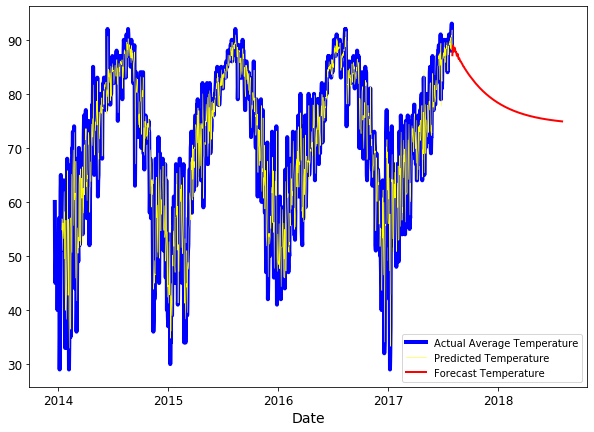

In [31]:
#
# visualize the predictions overlaid on the real data
# as well as the extrapolation to the future
#
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(df.Date, 
        df.TempAvgF, 
        c = "blue", 
        linewidth = 4,
        label = 'Actual Average Temperature')
ax.plot(pred_temp.loc[0 : len(df.TempAvgF), 'Date'], 
        pred_temp.loc[0 : len(df.TempAvgF), 'pred_temp'], 
        c = "yellow", 
        linewidth = 0.5,
        label = 'Predicted Temperature')
ax.plot(pred_temp.loc[len(df.TempAvgF):, 'Date'], 
        pred_temp.loc[len(df.TempAvgF):, 'pred_temp'], 
        c = "red", 
        linewidth = 2,
        label = 'Forecast Temperature')
ax.set_xlabel('Date', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
ax.legend()